#### Importando bibliotecas

In [1]:
# Importa todas as bibliotecas
import nibabel as nib
import numpy as np
import copy
import itertools
import os
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model, regularizers
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

#### Funções necessárias para armazenar os dados e rodar o modelo

In [2]:
# Funções para carregar as imagens já pré-processadas e calcular os labels
def calculate_label(image, threshold=0.05):
    """
    Determina o label da subimagem com base no percentual de fundo não-preto.
    :param subimage: Array da subimagem.
    :param threshold: Percentual mínimo de fundo não-preto para considerar como label 1.
    :return: String indicando o label.
    """
    # Total de pixels na subimagem
    total_pixels = image.size
    # Número de pixels não-preto
    non_zero_pixels = np.count_nonzero(image)
    # Proporção de pixels não-preto
    non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
    
    # Verifica se há lesão e se o fundo não-preto é maior que o limiar
    if np.any(image == 1) and non_black_ratio >= threshold:
        return 1
    else:
        return 0

def load_patient_data(folder, patient_id):
    """
    Carrega os dados de um único paciente (imagens, máscaras e labels) de um diretório.

    Args:
        folder (str): Caminho da pasta contendo os dados dos pacientes.
        patient_id (str): ID do paciente a ser carregado.

    Returns:
        dict: Dados do paciente, incluindo imagens, máscaras e labels para os lados esquerdo e direito.
              Retorna None se o paciente não for encontrado.
    """
    patient_path = os.path.join(folder, patient_id)
    if not os.path.exists(patient_path):
        print(f"Paciente {patient_id} não encontrado na pasta {folder}.")
        return None

    # Inicializa estruturas para armazenar os dados do paciente
    patient_data = {
        "images_left": [],
        "images_right": [],
        "mask_left": [],
        "mask_right": [],
        "labels_left": [],
        "labels_right": [],
    }

    areas_image = ["left", "right"]
    areas_mask = ["lesion_left", "lesion_right"]
    path_left = os.path.join(patient_path, areas_image[0])
    path_right = os.path.join(patient_path, areas_image[1])
    lesion_path_left = os.path.join(patient_path, areas_mask[0])
    lesion_path_right = os.path.join(patient_path, areas_mask[1])

    # Verifica se os diretórios existem
    if not os.path.exists(path_left) or not os.path.exists(path_right) or \
       not os.path.exists(lesion_path_left) or not os.path.exists(lesion_path_right):
        print(f"Estrutura de diretórios inválida para o paciente {patient_id}.")
        return None, None

    # Carrega as imagens e máscaras do lado esquerdo e direito
    for patch_id_left, mask_id_left, patch_id_right, mask_id_right in zip(
        os.listdir(path_left), os.listdir(lesion_path_left),
        os.listdir(path_right), os.listdir(lesion_path_right)
    ):
        img_path_left = os.path.join(path_left, patch_id_left)
        mask_path_left = os.path.join(lesion_path_left, mask_id_left)
        img_path_right = os.path.join(path_right, patch_id_right)
        mask_path_right = os.path.join(lesion_path_right, mask_id_right)

        for img_left, msk_left, img_right, msk_right in zip(
            os.listdir(img_path_left), os.listdir(mask_path_left),
            os.listdir(img_path_right), os.listdir(mask_path_right)
        ):
            # Carrega os dados do lado esquerdo
            data_left = nib.load(os.path.join(img_path_left, img_left)).get_fdata()
            data_msk_left = nib.load(os.path.join(mask_path_left, msk_left)).get_fdata()
            if len(data_left) > 0 or len(data_msk_left) > 0:
                patient_data["images_left"].append(data_left)
                patient_data["mask_left"].append(data_msk_left)
                patient_data["labels_left"].append(calculate_label(data_msk_left))

            # Carrega os dados do lado direito
            data_right = nib.load(os.path.join(img_path_right, img_right)).get_fdata()
            data_msk_right = nib.load(os.path.join(mask_path_right, msk_right)).get_fdata()
            if len(data_right) > 0 or len(data_msk_right) > 0:
                patient_data["images_right"].append(np.fliplr(data_right))
                patient_data["mask_right"].append(np.fliplr(data_msk_right))
                patient_data["labels_right"].append(calculate_label(data_msk_right))

    # Gera os pares de labels
    labels_pair = []
    for label_left, label_right in zip(patient_data["labels_left"], patient_data["labels_right"]):
        if label_left == 0 and label_right == 0:
            labels_pair.append(0)
        else:
            labels_pair.append(1)
    patient_data["labels_pair"] = labels_pair

    print(f"Paciente {patient_id} carregado com sucesso.")
    print(f"Total de recortes: {len(labels_pair)}")
    return patient_data, labels_pair

In [10]:
# Função para normalizar entre 0 e 1
def normalize_minmax(image_data_batch): # Esta é a normalize_minmax_specific_for_3channel_batch
    if not isinstance(image_data_batch, np.ndarray):
        raise TypeError("A entrada 'image_data_batch' deve ser um array NumPy.")
    if image_data_batch.size == 0:
        return image_data_batch
    if image_data_batch.ndim != 4 or image_data_batch.shape[-1] != 3:
        raise ValueError(f"Esperado shape (N, H, W, 3), mas recebeu {image_data_batch.shape}")

    # Cria uma cópia float para evitar alteração direta e garantir precisão
    image_data_batch = image_data_batch.astype(np.float32, copy=True)

    for idx in range(image_data_batch.shape[0]):  # para cada patch
        for channel in range(3):  # para cada canal/modalidade
            patch = image_data_batch[idx, ..., channel]
            min_val = np.min(patch)
            max_val = np.max(patch)
            if max_val == min_val:
                image_data_batch[idx, ..., channel] = 0.0
            else:
                image_data_batch[idx, ..., channel] = (patch - min_val) / (max_val - min_val)

    return image_data_batch

def augment_image(img_left, img_right, mask_left, mask_right):
    """
    Gera 7 variações (exceto a imagem original) aplicando:
    - rotação 180°
    - flip horizontal (np.fliplr para imagens HWC faz flip left-right)
    - troca de lado
    """

    def rotate_180(img): return ndi.rotate(img, 180, reshape=False, mode='nearest', order=0) # order=0 para máscaras
    def flip_horizontal(img): return np.fliplr(img) # Flip left-right

    results_left = []
    masks_left = []
    results_right = []
    masks_right = []
    
    # Todas as combinações possíveis, exceto a (False, False, False)
    for rotate_flag in [False, True]:
        for flip_flag in [False, True]:
            for swap_flag in [False, True]:
                if not (rotate_flag or flip_flag or swap_flag):  # pula a imagem padrão
                    continue

                l_img, r_img = img_left.copy(), img_right.copy()
                l_mask, r_mask = mask_left.copy(), mask_right.copy()

                if rotate_flag:
                    l_img, r_img = rotate_180(l_img), rotate_180(r_img)
                    l_mask, r_mask = rotate_180(l_mask), rotate_180(r_mask)
                if flip_flag:
                    l_img, r_img = flip_horizontal(l_img), flip_horizontal(r_img)
                    l_mask, r_mask = flip_horizontal(l_mask), flip_horizontal(r_mask)
                if swap_flag:
                    l_img, r_img = r_img, l_img # Swap images
                    l_mask, r_mask = r_mask, l_mask # Swap masks

                results_left.append(l_img)
                masks_left.append(l_mask)
                results_right.append(r_img)
                masks_right.append(r_mask)

    return results_left, results_right, masks_left, masks_right

def augment_single_image(img_left, img_right, mask_left, mask_right, rng):
    """
    Aplica uma única modificação aleatória entre 7 variações possíveis.
    """
    def rotate_180(img): return ndi.rotate(img, 180, reshape=False, mode='nearest', order=0)
    def flip_horizontal(img): return np.fliplr(img)

    transformations = [
        (True, False, False), (False, True, False), (False, False, True),
        (True, True, False), (True, False, True), (False, True, True),
        (True, True, True)
    ]
    
    # Escolhe aleatoriamente um índice de transformação
    chosen_idx = rng.choice(len(transformations))
    rotate_flag, flip_flag, swap_flag = transformations[chosen_idx]

    l_img, r_img = img_left.copy(), img_right.copy()
    l_mask, r_mask = mask_left.copy(), mask_right.copy()

    if rotate_flag:
        l_img, r_img = rotate_180(l_img), rotate_180(r_img)
        l_mask, r_mask = rotate_180(l_mask), rotate_180(r_mask)
    if flip_flag:
        l_img, r_img = flip_horizontal(l_img), flip_horizontal(r_img)
        l_mask, r_mask = flip_horizontal(l_mask), flip_horizontal(r_mask)
    if swap_flag:
        l_img, r_img = r_img, l_img
        l_mask, r_mask = r_mask, l_mask
        
    return l_img, r_img, l_mask, r_mask

def select_by_patients(patients_list_to_select, # Renomeado para clareza
                       all_images_left_dict, # Renomeado
                       all_images_right_dict, # Renomeado
                       all_labels_dict, # Renomeado
                       all_masks_left_dict = None, # Adicionado para máscaras
                       all_masks_right_dict = None): # Adicionado para máscaras
    
    # Estas serão listas planas de patches, não dicionários
    selected_patches_left = []
    selected_patches_right = []
    selected_final_labels = []
    selected_masks_left = [] if all_masks_left_dict is not None else None
    selected_masks_right = [] if all_masks_right_dict is not None else None
    
    for patient in patients_list_to_select:
        if patient in all_images_left_dict and \
           patient in all_images_right_dict and \
           patient in all_labels_dict:
            
            selected_patches_left.extend(all_images_left_dict[patient])
            selected_patches_right.extend(all_images_right_dict[patient])
            selected_final_labels.extend(all_labels_dict[patient])

            if all_masks_left_dict and patient in all_masks_left_dict:
                selected_masks_left.extend(all_masks_left_dict[patient])
            if all_masks_right_dict and patient in all_masks_right_dict:
                selected_masks_right.extend(all_masks_right_dict[patient])
        else:
            print(f"Paciente {patient} não encontrado consistentemente em todas as listas de dados de entrada para select_by_patients.")
            
    # Retorna listas de patches e labels, não dicionários.
    # A conversão para np.array é feita fora desta função, antes da normalização.
    if all_masks_left_dict is not None:
        return selected_patches_left, selected_patches_right, selected_final_labels, selected_masks_left, selected_masks_right
    else:
        return selected_patches_left, selected_patches_right, selected_final_labels

In [25]:
def prepare_data_for_training(images_left_all_patients, images_right_all_patients, 
                              labels_pair_all_patients, mask_left_all_patients, mask_right_all_patients, train_patients, valid_patients, test_patients,
                              train_size=0.7, validation_size=0.2, test_size=0.1): # Removido augment_factor
    
    # Dicionários para armazenar dados balanceados por paciente ANTES do split final
    balanced_img_l_per_patient = {}
    balanced_img_r_per_patient = {}
    balanced_lbl_per_patient = {}
    balanced_msk_l_per_patient = {}
    balanced_msk_r_per_patient = {}
    balanced_index_patients = {}

    # Divisão de pacientes (você pode reativar train_test_split se preferir)
    # train_patients = ['sub-02A13', 'sub-06C09', 'sub-14F04', 'sub-16E03', 'sub-16I12', 'sub-19F09', 'sub-19G04', 'sub-26B09', 'sub-31F07', 'sub-35E12', 'sub-36K02', 'sub-51C05', 'sub-52K04', 'sub-59G00', 'sub-60G13', 'sub-60K04', 'sub-71C07', 'sub-72K02', 'sub-76E02', 'sub-76J09', 'sub-83K08', 'sub-85I05']
    # valid_patients = ['sub-00H10', 'sub-29D03', 'sub-56E13', 'sub-60G06', 'sub-72I02', 'sub-86B13']
    # test_patients = ['sub-41D08','sub-42K06', 'sub-44H05']
    
    print(f"Total de pacientes: {len(train_patients) + len(valid_patients) + len(test_patients)}")

    all_patient_ids = list(images_left_all_patients.keys())

    for patient_id in all_patient_ids:
        # Listas temporárias para os dados do paciente atual
        patient_patches_l_cl1, patient_patches_r_cl1, patient_masks_l_cl1, patient_masks_r_cl1, patient_labels_cl1 = [], [], [], [], []
        patient_patches_l_cl0, patient_patches_r_cl0, patient_masks_l_cl0, patient_masks_r_cl0, patient_labels_cl0 = [], [], [], [], []

        seed = hash(patient_id) % (2**32)
        rng = np.random.default_rng(seed)
        
        if patient_id not in labels_pair_all_patients or len(labels_pair_all_patients[patient_id]) == 0:
            print(f"Paciente {patient_id} sem labels ou dados. Pulando.")
            continue
        
        # Para o conjunto de teste, não fazemos balanceamento nem augmentation
        if patient_id in test_patients:
            balanced_img_l_per_patient[patient_id] = images_left_all_patients[patient_id]
            balanced_img_r_per_patient[patient_id] = images_right_all_patients[patient_id]
            balanced_lbl_per_patient[patient_id] = labels_pair_all_patients[patient_id]
            balanced_msk_l_per_patient[patient_id] = mask_left_all_patients[patient_id]
            balanced_msk_r_per_patient[patient_id] = mask_right_all_patients[patient_id]
            continue
        
        # Separar dados do paciente atual em classe 0 e 1
        for index, label in enumerate(labels_pair_all_patients[patient_id]):
            img_l = images_left_all_patients[patient_id][index]
            img_r = images_right_all_patients[patient_id][index]
            msk_l = mask_left_all_patients[patient_id][index]
            msk_r = mask_right_all_patients[patient_id][index]
            
            if label == 1:
                patient_patches_l_cl1.append(img_l)
                patient_patches_r_cl1.append(img_r)
                patient_masks_l_cl1.append(msk_l)
                patient_masks_r_cl1.append(msk_r)
                patient_labels_cl1.append(label)
            else:
                patient_patches_l_cl0.append(img_l)
                patient_patches_r_cl0.append(img_r)
                patient_masks_l_cl0.append(msk_l)
                patient_masks_r_cl0.append(msk_r)
                patient_labels_cl0.append(label)
        
        count_cl1_initial = len(patient_labels_cl1)
        count_cl0_initial = len(patient_labels_cl0)
        print(f"Paciente {patient_id}: Classe 1 inicial: {count_cl1_initial}, Classe 0 inicial: {count_cl0_initial}")

        # 1. Uppersampling da classe minoritária (se for classe 1)
        if count_cl1_initial > 0 and count_cl1_initial < count_cl0_initial:
            temp_aug_img_l, temp_aug_img_r, temp_aug_msk_l, temp_aug_msk_r = [], [], [], []
            for i in range(count_cl1_initial):
                aug_l_list, aug_r_list, aug_m_l_list, aug_m_r_list = augment_image(
                    patient_patches_l_cl1[i], patient_patches_r_cl1[i],
                    patient_masks_l_cl1[i], patient_masks_r_cl1[i]
                )
                temp_aug_img_l.extend(aug_l_list)
                temp_aug_img_r.extend(aug_r_list)
                temp_aug_msk_l.extend(aug_m_l_list)
                temp_aug_msk_r.extend(aug_m_r_list)
            
            patient_patches_l_cl1.extend(temp_aug_img_l)
            patient_patches_r_cl1.extend(temp_aug_img_r)
            patient_masks_l_cl1.extend(temp_aug_msk_l)
            patient_masks_r_cl1.extend(temp_aug_msk_r)
            patient_labels_cl1.extend([1] * len(temp_aug_img_l))
            print(f"  Classe 1 após uppersampling: {len(patient_labels_cl1)}")

        # 2. Augmentation opcional da Classe 0 (majoritária ou já balanceada)
        augmented_patient_patches_l_cl0 = []
        augmented_patient_patches_r_cl0 = []
        augmented_patient_masks_l_cl0 = []
        augmented_patient_masks_r_cl0 = []

        for i in range(len(patient_patches_l_cl0)): # Iterar sobre as amostras originais da classe 0
            img_l, img_r = patient_patches_l_cl0[i], patient_patches_r_cl0[i]
            msk_l, msk_r = patient_masks_l_cl0[i], patient_masks_r_cl0[i]
            
            # Usar um novo rng para esta decisão para não afetar o sampling depois
            temp_rng_for_aug_cl0 = np.random.default_rng(seed + i + 1) # Seed diferente
            if temp_rng_for_aug_cl0.random() < 0.5: # Ex: 50% de chance de augmentar
                aug_l, aug_r, aug_m_l, aug_m_r = augment_single_image(img_l, img_r, msk_l, msk_r, rng) # Usa o rng principal do paciente
                augmented_patient_patches_l_cl0.append(aug_l)
                augmented_patient_patches_r_cl0.append(aug_r)
                augmented_patient_masks_l_cl0.append(aug_m_l)
                augmented_patient_masks_r_cl0.append(aug_m_r)
            else:
                augmented_patient_patches_l_cl0.append(img_l)
                augmented_patient_patches_r_cl0.append(img_r)
                augmented_patient_masks_l_cl0.append(msk_l)
                augmented_patient_masks_r_cl0.append(msk_r)
        
        patient_patches_l_cl0 = augmented_patient_patches_l_cl0
        patient_patches_r_cl0 = augmented_patient_patches_r_cl0
        patient_masks_l_cl0 = augmented_patient_masks_l_cl0
        patient_masks_r_cl0 = augmented_patient_masks_r_cl0

        # 3. Undersampling da classe majoritária para igualar à minoritária (APÓS uppersampling e aug da classe 0)
        count_cl1_current = len(patient_labels_cl1)
        count_cl0_current = len(patient_labels_cl0)

        if count_cl0_current > count_cl1_current and count_cl1_current > 0:
            sampled_indices = rng.choice(count_cl0_current, count_cl1_current, replace=False)
            patient_patches_l_cl0 = [patient_patches_l_cl0[i] for i in sampled_indices]
            patient_patches_r_cl0 = [patient_patches_r_cl0[i] for i in sampled_indices]
            patient_masks_l_cl0 = [patient_masks_l_cl0[i] for i in sampled_indices]
            patient_masks_r_cl0 = [patient_masks_r_cl0[i] for i in sampled_indices]
            patient_labels_cl0 = [0] * count_cl1_current
        elif count_cl1_current > count_cl0_current and count_cl0_current > 0:
            sampled_indices = rng.choice(count_cl1_current, count_cl0_current, replace=False)
            patient_patches_l_cl1 = [patient_patches_l_cl1[i] for i in sampled_indices]
            patient_patches_r_cl1 = [patient_patches_r_cl1[i] for i in sampled_indices]
            patient_masks_l_cl1 = [patient_masks_l_cl1[i] for i in sampled_indices]
            patient_masks_r_cl1 = [patient_masks_r_cl1[i] for i in sampled_indices]
            patient_labels_cl1 = [1] * count_cl0_current
        
        print(f"  Paciente {patient_id}: Final Classe 1: {len(patient_labels_cl1)}, Final Classe 0: {len(patient_labels_cl0)}")

        # Combinar e embaralhar para este paciente
        final_patches_l = patient_patches_l_cl1 + patient_patches_l_cl0
        final_patches_r = patient_patches_r_cl1 + patient_patches_r_cl0
        final_masks_l = patient_masks_l_cl1 + patient_masks_l_cl0
        final_masks_r = patient_masks_r_cl1 + patient_masks_r_cl0
        final_labels = patient_labels_cl1 + patient_labels_cl0

        if not final_labels:
            print(f"  Paciente {patient_id} sem dados após balanceamento. Pulando.")
            continue
        
        shuffle_indices = rng.choice(len(final_labels), len(final_labels), replace=False)
        
        balanced_img_l_per_patient[patient_id] = [final_patches_l[i] for i in shuffle_indices]
        balanced_img_r_per_patient[patient_id] = [final_patches_r[i] for i in shuffle_indices]
        balanced_lbl_per_patient[patient_id] = [final_labels[i] for i in shuffle_indices]
        balanced_msk_l_per_patient[patient_id] = [final_masks_l[i] for i in shuffle_indices]
        balanced_msk_r_per_patient[patient_id] = [final_masks_r[i] for i in shuffle_indices]
        balanced_index_patients[patient_id] = shuffle_indices

    # Selecionar dados para os conjuntos de treino, validação e teste (agora com máscaras)
    X_train_l, X_train_r, y_train, M_train_l, M_train_r = select_by_patients(
        train_patients, balanced_img_l_per_patient, balanced_img_r_per_patient, 
        balanced_lbl_per_patient, balanced_msk_l_per_patient, balanced_msk_r_per_patient
    )
    X_val_l, X_val_r, y_val, M_val_l, M_val_r = select_by_patients(
        valid_patients, balanced_img_l_per_patient, balanced_img_r_per_patient, 
        balanced_lbl_per_patient, balanced_msk_l_per_patient, balanced_msk_r_per_patient
    )
    X_test_l, X_test_r, y_test, M_test_l, M_test_r = select_by_patients(
        test_patients, balanced_img_l_per_patient, balanced_img_r_per_patient, 
        balanced_lbl_per_patient, balanced_msk_l_per_patient, balanced_msk_r_per_patient
    )
    
    print(f"Total de pares de recortes no treino ({len(train_patients)} pacientes) com label 1: {y_train.count(1)}, label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({len(valid_patients)} pacientes) com label 1: {y_val.count(1)}, label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste ({len(test_patients)} pacientes) com label 1: {y_test.count(1)}, label 0: {y_test.count(0)}")
    

    return (X_train_l, X_train_r, X_val_l, X_val_r, X_test_l, X_test_r, 
            np.array(y_train), np.array(y_val), np.array(y_test),
            train_patients, valid_patients, test_patients,
            np.array(M_train_l), np.array(M_train_r), np.array(M_val_l), np.array(M_val_r), np.array(M_test_l), np.array(M_test_r),
            balanced_index_patients)

In [5]:
# Função para preparar os dados para treino e validação pareados
def prepare_data_aligned(images_left, images_right, labels_pair, mask_left, mask_right):
    import numpy as np

    patients = list(images_left.keys())

    train_patients_split = ['sub-02A13', 'sub-03C08', 'sub-06C09', 'sub-14F04', 'sub-16E03', 'sub-16G09', 'sub-16I12', 'sub-19F09', 'sub-19G04', 'sub-22F14', 'sub-26B09', 'sub-31F07', 'sub-35E12', 'sub-36K02', 'sub-41D08', 'sub-51C05', 'sub-52K04', 'sub-57D04', 'sub-59G00', 'sub-60G13', 'sub-60K04', 'sub-71C07', 'sub-72I02', 'sub-72K02', 'sub-76E02', 'sub-76J09', 'sub-83K08', 'sub-85I05', 'sub-86B13']
    val_patients_split = ['sub-00H10', 'sub-25B08', 'sub-29D03', 'sub-34J06', 'sub-56E13', 'sub-59E09', 'sub-60G06', 'sub-79H07']
    test_patients_split = ['sub-42B05', 'sub-42K06', 'sub-44H05', 'sub-86G08']


    patches_per_patient = {}
    for patient in patients:
        patches_per_patient[patient] = []
        for idx, label in enumerate(labels_pair[patient]):
            patch_info = {
                'index': idx,
                'image_left': images_left[patient][idx],
                'image_right': images_right[patient][idx],
                'mask_left': mask_left[patient][idx],
                'mask_right': mask_right[patient][idx],
                'label': label
            }
            patches_per_patient[patient].append(patch_info)

    paired_displasia = []
    paired_saudavel = []

    patient_ids = sorted(patients)
    for i in test_patients_split:
        if i in patient_ids:
            patient_ids.remove(i)

    for patient in test_patients_split:
        for patch in patches_per_patient[patient]:
            if patch['label'] == 1:
                paired_displasia.append((patient, patch))
            else:
                paired_saudavel.append((patient, patch))

    for i in range(len(patient_ids) - 1):
        patient_current = patient_ids[i]
        patient_next = patient_ids[i + 1]

        patches_current = patches_per_patient[patient_current]
        patches_next = patches_per_patient[patient_next]

        displasia_indices = [p['index'] for p in patches_current if p['label'] == 1]

        if not displasia_indices:
            print(f"Paciente {patient_current} sem regiões de displasia.")
            continue

        min_idx = min(displasia_indices)
        max_idx = max(displasia_indices)

        print(f"Paciente {patient_current} displasia de {min_idx} a {max_idx}.")

        for idx in range(min_idx, max_idx + 1):
            if idx < len(patches_current) and patches_current[idx]['label'] == 1:
                paired_displasia.append((patient_current, patches_current[idx]))

        valid_saudavel = True
        for idx in range(min_idx, max_idx + 1):
            if idx >= len(patches_next) or patches_next[idx]['label'] == 1:
                valid_saudavel = False
                break

        if valid_saudavel:
            for idx in range(min_idx, max_idx + 1):
                paired_saudavel.append((patient_next, patches_next[idx]))
        else:
            print(f"Conflito de indices no paciente {patient_next}, randomizando saudáveis.")
            saudaveis = [p for p in patches_next if p['label'] == 0]
            rng = np.random.default_rng(hash(patient_current + patient_next) % (2 ** 32))
            selected = rng.choice(saudaveis, size=(max_idx - min_idx + 1), replace=True)
            for s in selected:
                paired_saudavel.append((patient_next, s))

    all_data = paired_displasia + paired_saudavel

    data_by_patient = {}
    for patient, patch in all_data:
        if patient not in data_by_patient:
            data_by_patient[patient] = []
        data_by_patient[patient].append(patch)

    selected_indices_by_patient = {}

    def collect_data(patient_split, boolean):
        X_left, X_right, y = [], [], []
        M_left, M_right = [], []

        patch_metadata = []  # vai guardar (paciente, idx_original) para mapear depois

        for patient in patient_split:
            for patch in data_by_patient.get(patient, []):
                X_left.append(patch['image_left'])
                X_right.append(patch['image_right'])
                M_left.append(patch['mask_left'])
                M_right.append(patch['mask_right'])
                y.append(patch['label'])
                patch_metadata.append((patient, patch['index']))

        if boolean:
            rng = np.random.default_rng(42)
            indices_class_1 = [i for i, label in enumerate(y) if label == 1]
            indices_class_0 = [i for i, label in enumerate(y) if label == 0]

            min_class = min(len(indices_class_1), len(indices_class_0))
            selected_indices_class_1 = rng.choice(indices_class_1, min_class, replace=False)
            selected_indices_class_0 = rng.choice(indices_class_0, min_class, replace=False)

            selected_indices = np.concatenate((selected_indices_class_1, selected_indices_class_0))
            rng.shuffle(selected_indices)

            X_left = [X_left[i] for i in selected_indices]
            X_right = [X_right[i] for i in selected_indices]
            M_left = [M_left[i] for i in selected_indices]
            M_right = [M_right[i] for i in selected_indices]
            y = [y[i] for i in selected_indices]
            patch_metadata = [patch_metadata[i] for i in selected_indices]

        # Reconstruir o dicionário de índices por paciente
        local_selected = {}
        for i, (patient, idx_original) in enumerate(patch_metadata):
            if patient not in local_selected:
                local_selected[patient] = []
            local_selected[patient].append(i)  # i é o índice final (em X_left, y, etc.)

        return X_left, X_right, M_left, M_right, y, local_selected


    X_train_original, X_train_opposite, M_train_left, M_train_right, y_train, train_selected = collect_data(train_patients_split, True)
    X_val_original, X_val_opposite, M_val_left, M_val_right, y_val, val_selected = collect_data(val_patients_split, True)
    X_test_original, X_test_opposite, M_test_left, M_test_right, y_test, test_selected = collect_data(test_patients_split, False)

    selected_indices_by_patient = {
        'train': train_selected,
        'val': val_selected,
        'test': test_selected
    }

    print(f"Total de pares de recortes no treino com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com label 0: {y_test.count(0)}")

    return (
        np.array(X_train_original), np.array(X_train_opposite),
        np.array(X_val_original), np.array(X_val_opposite),
        np.array(X_test_original), np.array(X_test_opposite),
        np.array(y_train), np.array(y_val), np.array(y_test),
        train_patients_split, val_patients_split, test_patients_split,
        np.array(M_train_left), np.array(M_train_right),
        np.array(M_val_left), np.array(M_val_right),
        np.array(M_test_left), np.array(M_test_right),
        selected_indices_by_patient
    )

In [6]:
# Função para construir o modelo CNN 2D
def build_cnn_model_backup():
    model = models.Sequential()
    
    model.add(layers.Conv2D(8, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(16, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    # model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3)) 
     
    model.add(layers.Conv2D(32, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    # model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())

    return model

In [7]:
# Função para construir a rede siamesa
def build_siamese_model(input_shape):
    input_original = Input(shape=input_shape)
    input_opposite = Input(shape=input_shape)

    # Criar a CNN base compartilhada
    cnn_base = build_cnn_model_backup()
    
    # Aplicar a mesma CNN base para ambas as entradas
    output_original = cnn_base(input_original)
    output_opposite = cnn_base(input_opposite)

    # Calcula a diferença absoluta
    # l1_distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([output_original, output_opposite])

    # Subtrair as duas saídas (Lado esquerdo - Contra-lateral)
    subtracted = layers.Subtract()([output_original, output_opposite])
    subtracted = layers.BatchNormalization()(subtracted)

    # Concatenar as duas saídas (Lado esquerdo + Contra-lateral)
    # concatenated = layers.Concatenate()([output_original, output_opposite])
    # concatenated = layers.BatchNormalization()(concatenated)
    
    # Passar o resultado pela rede densa
    subtracted = layers.Dense(64, activation='relu')(subtracted)
    subtracted = layers.Dropout(0.3)(subtracted)
    subtracted = layers.Dense(32, activation='relu')(subtracted)
    subtracted = layers.Dropout(0.3)(subtracted)

    output = layers.Dense(1, activation='sigmoid')(subtracted)

    siamese_model = Model(inputs=[input_original, input_opposite], outputs=output)
    siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")])

    return siamese_model


In [8]:
# Função de plot do treinamento do modelo
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [9]:
# Função de plot da matriz de confusão
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


#### Rodando função de Pré-Processamento

In [11]:
# Pastas com os tipos
folder_T1 = "Novo_Contralateral/Contralateral_T1"
folder_FLAIR = "Novo_Contralateral/Contralateral_Flair"
folder_T2 = "Novo_Contralateral/Contralateral_T2"

# Dicionários para cada modalidade
data_T1, data_FLAIR, data_T2 = {}, {}, {}

# Função genérica para carregar dados por modalidade
def load_all_modalities(folder, modality_dict, modality_type):
    print("Modalidade de imagem: " + modality_type)
    for patient_id in os.listdir(folder):
        patient_data, labels_pair = load_patient_data(folder, patient_id)
        if patient_data is not None:
            modality_dict[patient_id] = {
                "images_left": patient_data["images_left"],
                "images_right": patient_data["images_right"],
                "mask_left": patient_data["mask_left"],
                "mask_right": patient_data["mask_right"],
                "labels_pair": labels_pair
            }
    print("\n")

# Carrega os dados das três modalidades
load_all_modalities(folder_T1, data_T1, "T1")
load_all_modalities(folder_FLAIR, data_FLAIR, "Flair")
load_all_modalities(folder_T2, data_T2, "T2")

# Agora criamos os dicionários finais
X_rgb_left, X_rgb_right = {}, {}
mask_left, mask_right, y = {}, {}, {}

for patient_id in data_T1:
    if patient_id in data_FLAIR and patient_id in data_T2:
        # Junta as três modalidades no eixo da cor
        img_rgb_left = np.stack([
            data_T1[patient_id]["images_left"],
            data_FLAIR[patient_id]["images_left"],
            data_T2[patient_id]["images_left"]
        ], axis=-1)

        img_rgb_right = np.stack([
            data_T1[patient_id]["images_right"],
            data_FLAIR[patient_id]["images_right"],
            data_T2[patient_id]["images_right"]
        ], axis=-1)

        # Armazena
        X_rgb_left[patient_id] = img_rgb_left
        X_rgb_right[patient_id] = img_rgb_right
        mask_left[patient_id] = data_T1[patient_id]["mask_left"]
        mask_right[patient_id] = data_T1[patient_id]["mask_right"]
        y[patient_id] = data_T1[patient_id]["labels_pair"]

Modalidade de imagem: T1
Paciente sub-00H10 carregado com sucesso.
Total de recortes: 1201
Paciente sub-02A13 carregado com sucesso.
Total de recortes: 1229
Paciente sub-06C09 carregado com sucesso.
Total de recortes: 1210
Paciente sub-14F04 carregado com sucesso.
Total de recortes: 1236
Paciente sub-16E03 carregado com sucesso.
Total de recortes: 1300
Paciente sub-16I12 carregado com sucesso.
Total de recortes: 1276
Paciente sub-19F09 carregado com sucesso.
Total de recortes: 1275
Paciente sub-19G04 carregado com sucesso.
Total de recortes: 1262
Paciente sub-26B09 carregado com sucesso.
Total de recortes: 1234
Paciente sub-29D03 carregado com sucesso.
Total de recortes: 1213
Paciente sub-31F07 carregado com sucesso.
Total de recortes: 1239
Paciente sub-35E12 carregado com sucesso.
Total de recortes: 1210
Paciente sub-36K02 carregado com sucesso.
Total de recortes: 1235
Paciente sub-41D08 carregado com sucesso.
Total de recortes: 1174
Paciente sub-42K06 carregado com sucesso.
Total de 

In [12]:
# Preparar dados para treino, validação e teste
(train_left_balanced, train_right_balanced, valid_left_balanced, valid_right_balanced, test_left, test_right,
 y_train_balanced, y_valid_balanced, y_test,
 train_p_ids, val_p_ids, test_p_ids,
 train_l_masks, train_r_masks, val_l_masks, val_r_masks, test_l_masks, test_r_masks,
 balanced_index_patients) = prepare_data_for_training(X_rgb_left, X_rgb_right, y, mask_left, mask_right)

train_left_balanced = normalize_minmax(np.array(train_left_balanced))
train_right_balanced = normalize_minmax(np.array(train_right_balanced))
valid_left_balanced = normalize_minmax(np.array(valid_left_balanced))
valid_right_balanced = normalize_minmax(np.array(valid_right_balanced))
test_left           = normalize_minmax(np.array(test_left))
test_right          = normalize_minmax(np.array(test_right))

# train_left_balanced, train_right_balanced, valid_left_balanced, valid_right_balanced, test_left, test_right, y_train_balanced, y_valid_balanced, y_test, train_patients, valid_patients, test_patients, mask_train_left, mask_train_right, mask_valid_left, mask_valid_right, mask_test_left, mask_test_right, paired_index_dictionary = prepare_data_aligned(X_rgb_left, X_rgb_right, y, mask_left, mask_right)
# train_left_balanced = normalize_minmax(train_left_balanced)
# train_right_balanced = normalize_minmax(train_right_balanced)
# valid_left_balanced = normalize_minmax(valid_left_balanced)
# valid_right_balanced = normalize_minmax(valid_right_balanced)
# test_left = normalize_minmax(test_left)
# test_right = normalize_minmax(test_right)

Total de pacientes: 31
Paciente sub-00H10: Classe 1 inicial: 15, Classe 0 inicial: 1186
  Classe 1 após uppersampling: 120
  Paciente sub-00H10: Final Classe 1: 120, Final Classe 0: 120
Paciente sub-02A13: Classe 1 inicial: 97, Classe 0 inicial: 1132
  Classe 1 após uppersampling: 776
  Paciente sub-02A13: Final Classe 1: 776, Final Classe 0: 776
Paciente sub-06C09: Classe 1 inicial: 8, Classe 0 inicial: 1202
  Classe 1 após uppersampling: 64
  Paciente sub-06C09: Final Classe 1: 64, Final Classe 0: 64
Paciente sub-14F04: Classe 1 inicial: 8, Classe 0 inicial: 1228
  Classe 1 após uppersampling: 64
  Paciente sub-14F04: Final Classe 1: 64, Final Classe 0: 64
Paciente sub-16E03: Classe 1 inicial: 130, Classe 0 inicial: 1170
  Classe 1 após uppersampling: 1040
  Paciente sub-16E03: Final Classe 1: 1040, Final Classe 0: 1040
Paciente sub-16I12: Classe 1 inicial: 27, Classe 0 inicial: 1249
  Classe 1 após uppersampling: 216
  Paciente sub-16I12: Final Classe 1: 216, Final Classe 0: 216
Pac

In [17]:
# Construir e compilar o modelo CNN
input_shape = (train_left_balanced[0].shape)

siamese_model = build_siamese_model(input_shape)
siamese_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 40, 40, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 40, 40, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 2304)      │     25,008 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_2          │ (None, 2304)      │          0 │ sequential_2[0][… │
│ (Subtract)          │                   │            │ sequential_2[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2304)      │      9,216 │ subtract_2[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │    147,520 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 32)        │          0 │ dense_7[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         33 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 183,857 (718.19 KB)

 Trainable params: 179,009 (699.25 KB)

 Non-trainable params: 4,848 (18.94 KB)

In [18]:
# Adicionar o callback EarlyStopping e low rate scheduler
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

# Ajusta learning rate
# reduce_lr = callbacks.ReduceLROnPlateau(factor=0.8, patience=15, verbose=1)

# Suponha que seus rótulos estejam em y_train_balanced
# classes = np.unique(y_valid_balanced)
# weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_valid_balanced)
# class_weight_dict = dict(zip(classes, weights))

# Salvar a melhor epoca
checkpoint = callbacks.ModelCheckpoint('best_model.weights.h5', monitor='val_loss', save_best_only=True,  save_weights_only=True, mode='min')

# Treinamento do modelo siames
history = siamese_model.fit([train_left_balanced, train_right_balanced], y_train_balanced, validation_data=([valid_left_balanced, valid_right_balanced], y_valid_balanced), batch_size=128, epochs=150, callbacks=[checkpoint])

Epoch 1/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step - accuracy: 0.4972 - loss: 0.7944 - precision: 0.5002 - recall: 0.5105 - val_accuracy: 0.4963 - val_loss: 0.6932 - val_precision: 0.4966 - val_recall: 0.5470
Epoch 2/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step - accuracy: 0.5047 - loss: 0.7050 - precision: 0.5025 - recall: 0.4762 - val_accuracy: 0.4961 - val_loss: 0.6933 - val_precision: 0.4814 - val_recall: 0.1008
Epoch 3/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 32s 156ms/step - accuracy: 0.5107 - loss: 0.6970 - precision: 0.5095 - recall: 0.4147 - val_accuracy: 0.4976 - val_loss: 0.6934 - val_precision: 0.4691 - val_recall: 0.0370
Epoch 4/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step - accuracy: 0.5042 - loss: 0.6954 - precision: 0.5048 - recall: 0.3788 - val_accuracy: 0.4950 - val_loss: 0.6936 - val_precision: 0.3719 - val_recall: 0.0146
Epoch 5/150
205/205 ━━━━━━━━━━━━━━━━━━━━ 36s 174ms/step - accuracy: 0.5176 - loss: 0.6925 - precision: 0.5302 - recall: 0.3633 - val_accuracy: 0

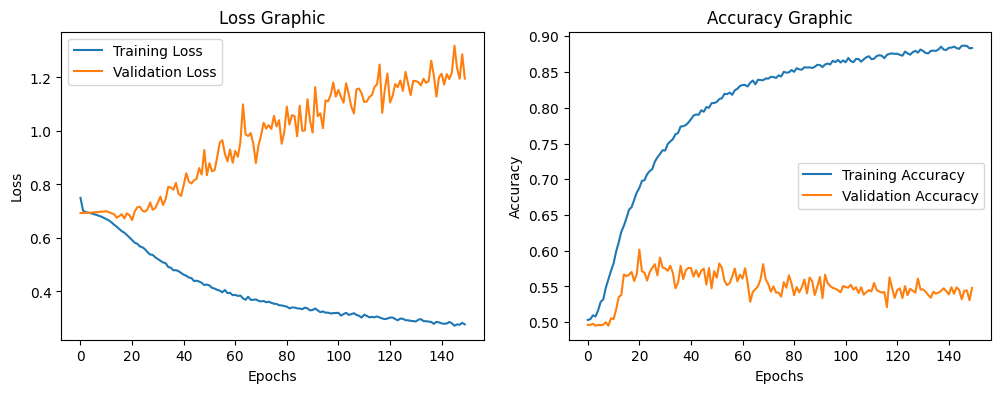

In [19]:
# Plotar o histórico do treinamento
plot_training_history(history)

820/820 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


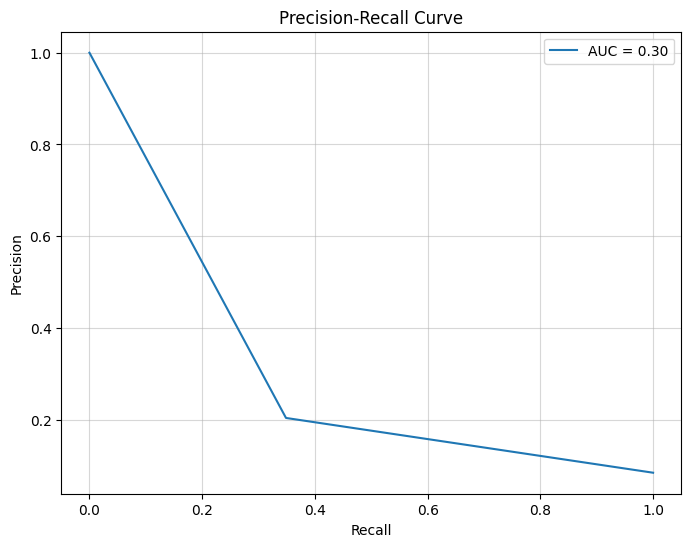

In [20]:
# Carregando pesos da melhor época
siamese_model.load_weights('best_model.weights.h5')

# Avaliar o modelo na validação
y_pred_train = (siamese_model.predict([train_left_balanced, train_right_balanced]) > 0.5).astype(int)

# Avaliar o modelo na validação
y_pred_valid = (siamese_model.predict([valid_left_balanced, valid_right_balanced]) > 0.5).astype(int)

# Avaliar o modelo no teste
y_pred_test = (siamese_model.predict([test_left, test_right]) > 0.5).astype(int)

# Calcula a curva precision-recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_test)

# Calcula a AUC precision-recall
auc_pr = auc(recall, precision)

# Plote a curva precision-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(alpha=0.5)
plt.show()

In [21]:
# Gerar o relatório de classificação
print("Treino:")
print(classification_report(y_train_balanced, y_pred_train))
print("\n#########################################################\n")
print("Validação:")
print(classification_report(y_valid_balanced, y_pred_valid))
print("\n#########################################################\n")
print("Teste:")
#print(classification_report(y_test, y_pred_test)) 
print(classification_report(y_test, y_pred_test)) 

Treino:
              precision    recall  f1-score   support

           0       0.66      0.90      0.76     13108
           1       0.84      0.54      0.66     13108

    accuracy                           0.72     26216
   macro avg       0.75      0.72      0.71     26216
weighted avg       0.75      0.72      0.71     26216


#########################################################

Validação:
              precision    recall  f1-score   support

           0       0.57      0.84      0.68      3084
           1       0.69      0.36      0.48      3084

    accuracy                           0.60      6168
   macro avg       0.63      0.60      0.58      6168
weighted avg       0.63      0.60      0.58      6168


#########################################################

Teste:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      3315
           1       0.20      0.35      0.26       304

    accuracy                        

Validação:


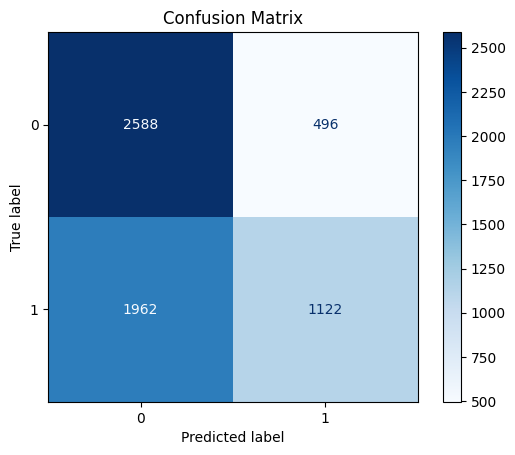

Teste:


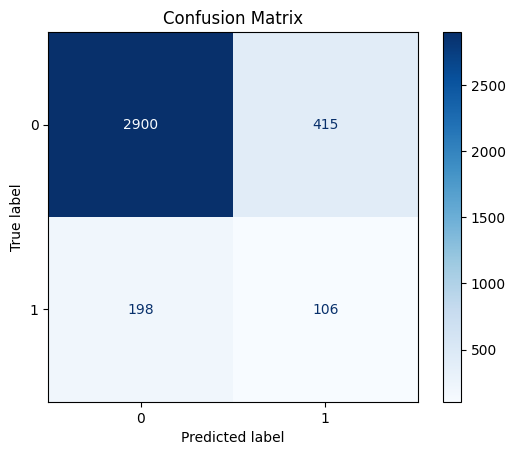

In [22]:
# Gerar a matriz de confusão
print("Validação:")
plot_confusion_matrix(y_valid_balanced, y_pred_valid)
print("Teste:")
plot_confusion_matrix(y_test, y_pred_test)

#### Estratégia Leave-One-Out

In [28]:
def run_leave_one_out_training(images_left_all_patients, images_right_all_patients, 
                                 labels_pair_all_patients, mask_left_all_patients, mask_right_all_patients,
                                 validation_ratio=0.2, build_model_fn=None, normalize_fn=None,
                                 train_epochs=150, batch_size=128, save_folder="models_loocv"):

    os.makedirs(save_folder, exist_ok=True)
    all_patients = list(images_left_all_patients.keys())
    results = []

    for test_patient in all_patients:
        print(f"\n==== Fold: Teste com {test_patient} ====")
        others = [p for p in all_patients if p != test_patient]
        train_patients, val_patients = train_test_split(others, test_size=validation_ratio, random_state=42)

        # Preparar dados
        (X_train_l, X_train_r, X_val_l, X_val_r, X_test_l, X_test_r,
         y_train, y_val, y_test,
         _, _, _,
         M_train_l, M_train_r, M_val_l, M_val_r, M_test_l, M_test_r,
         _) = prepare_data_for_training(
            images_left_all_patients, images_right_all_patients,
            labels_pair_all_patients, mask_left_all_patients, mask_right_all_patients,
            train_patients=train_patients, valid_patients=val_patients, test_patients=[test_patient]
        )

        # Normalizar se função fornecida
        if normalize_fn:
            X_train_l = normalize_fn(np.array(X_train_l))
            X_train_r = normalize_fn(np.array(X_train_r))
            X_val_l   = normalize_fn(np.array(X_val_l))
            X_val_r   = normalize_fn(np.array(X_val_r))
            X_test_l  = normalize_fn(np.array(X_test_l))
            X_test_r  = normalize_fn(np.array(X_test_r))

        # Construir modelo
        input_shape = X_train_l[0].shape
        model = build_model_fn(input_shape)

        # Callbacks
        model_path = os.path.join(save_folder, f"best_model_{test_patient}.weights.h5")
        checkpoint = callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, save_weights_only=True)

        # Treinar
        history = model.fit([X_train_l, X_train_r], y_train,
                            validation_data=([X_val_l, X_val_r], y_val),
                            epochs=train_epochs, batch_size=batch_size, callbacks=[checkpoint], verbose=0)

        model.load_weights(model_path)

        y_pred = (model.predict([X_test_l, X_test_r]) > 0.5).astype(int)

        # Avaliação
        report = classification_report(y_test, y_pred, output_dict=True)
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        auc_score = auc(recall, precision)

        results.append({
            "test_patient": test_patient,
            "report": report,
            "auc_pr": auc_score,
            "precision": precision,
            "recall": recall,
            "history": history.history
        })

        print(f"AUC-PR Fold {test_patient}: {auc_score:.4f}")
        print(classification_report(y_test, y_pred))

    return results

results = run_leave_one_out_training(
    X_rgb_left, X_rgb_right, y, mask_left, mask_right,
    validation_ratio=0.2,
    build_model_fn=build_siamese_model,
    normalize_fn=normalize_minmax,
    train_epochs=150,
    batch_size=128
)


==== Fold: Teste com sub-00H10 ====
Total de pacientes: 31
Paciente sub-02A13: Classe 1 inicial: 97, Classe 0 inicial: 1132
  Classe 1 após uppersampling: 776
  Paciente sub-02A13: Final Classe 1: 776, Final Classe 0: 776
Paciente sub-06C09: Classe 1 inicial: 8, Classe 0 inicial: 1202
  Classe 1 após uppersampling: 64
  Paciente sub-06C09: Final Classe 1: 64, Final Classe 0: 64
Paciente sub-14F04: Classe 1 inicial: 8, Classe 0 inicial: 1228
  Classe 1 após uppersampling: 64
  Paciente sub-14F04: Final Classe 1: 64, Final Classe 0: 64
Paciente sub-16E03: Classe 1 inicial: 130, Classe 0 inicial: 1170
  Classe 1 após uppersampling: 1040
  Paciente sub-16E03: Final Classe 1: 1040, Final Classe 0: 1040
Paciente sub-16I12: Classe 1 inicial: 27, Classe 0 inicial: 1249
  Classe 1 após uppersampling: 216
  Paciente sub-16I12: Final Classe 1: 216, Final Classe 0: 216
Paciente sub-19F09: Classe 1 inicial: 175, Classe 0 inicial: 1100
  Classe 1 após uppersampling: 1400
  Paciente sub-19F09: Final

c:\Users\Gabriel Panza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel Panza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel Panza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1113
           1       0.06      1.00      0.11        69

    accuracy                           0.06      1182
   macro avg       0.03      0.50      0.06      1182
weighted avg       0.00      0.06      0.01      1182


==== Fold: Teste com sub-59G00 ====
Total de pacientes: 31
Paciente sub-00H10: Classe 1 inicial: 15, Classe 0 inicial: 1186
  Classe 1 após uppersampling: 120
  Paciente sub-00H10: Final Classe 1: 120, Final Classe 0: 120
Paciente sub-02A13: Classe 1 inicial: 97, Classe 0 inicial: 1132
  Classe 1 após uppersampling: 776
  Paciente sub-02A13: Final Classe 1: 776, Final Classe 0: 776
Paciente sub-06C09: Classe 1 inicial: 8, Classe 0 inicial: 1202
  Classe 1 após uppersampling: 64
  Paciente sub-06C09: Final Classe 1: 64, Final Classe 0: 64
Paciente sub-14F04: Classe 1 inicial: 8, Classe 0 inicial: 1228
  Classe 1 após uppersampling: 64
  Paciente sub-14F04: Final Cl

c:\Users\Gabriel Panza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel Panza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel Panza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

#### Rodando processos de Pós-Processamento

In [ ]:
def load_patient_data_per_slice(folder, patient_id): # carregar dados de teste, mantendo os dados de cada fatia em um vetor
    patient_path = os.path.join(folder, patient_id)  # folder/patient/
    if not os.path.exists(patient_path):
        print(f"Paciente {patient_id} não encontrado na pasta {folder}.")
        return None

    # Inicializa estruturas para armazenar os dados do paciente
    patient_data = {
        "images_left": [],
        "images_right": [],
        "mask_left": [],
        "mask_right": [],
        "labels_left": [],
        "labels_right": [],
    }

    labels_total = []
    areas_image = ["left", "right"]
    areas_mask = ["lesion_left", "lesion_right"]
    path_left = os.path.join(patient_path, areas_image[0])  # folder/patient/left
    path_right = os.path.join(patient_path, areas_image[1])
    lesion_path_left = os.path.join(patient_path, areas_mask[0])
    lesion_path_right = os.path.join(patient_path, areas_mask[1])

    # Verifica se os diretórios existem
    if not os.path.exists(path_left) or not os.path.exists(path_right) or \
       not os.path.exists(lesion_path_left) or not os.path.exists(lesion_path_right):
        print(f"Estrutura de diretórios inválida para o paciente {patient_id}.")
        return None

    # Carrega as imagens e máscaras do lado esquerdo e direito
    for patch_id_left, mask_id_left, patch_id_right, mask_id_right in zip(
        os.listdir(path_left), os.listdir(lesion_path_left),
        os.listdir(path_right), os.listdir(lesion_path_right)
    ):
        img_path_left = os.path.join(path_left, patch_id_left)  # folder/patient/left/slice_
        mask_path_left = os.path.join(lesion_path_left, mask_id_left)
        img_path_right = os.path.join(path_right, patch_id_right)
        mask_path_right = os.path.join(lesion_path_right, mask_id_right)
        
        slice_left_img = []
        slice_right_img = []
        slice_left_mask = []
        slice_right_mask = []
        slice_left_labels = []
        slice_right_labels = []

        for img_left, msk_left, img_right, msk_right in zip(
            os.listdir(img_path_left), os.listdir(mask_path_left),
            os.listdir(img_path_right), os.listdir(mask_path_right)
        ):
            # Carrega os dados do lado esquerdo
            data_left = nib.load(os.path.join(img_path_left, img_left)).get_fdata()
            data_msk_left = nib.load(os.path.join(mask_path_left, msk_left)).get_fdata()

            if len(data_left) > 0 or len(data_msk_left) > 0:
                slice_left_img.append(data_left)
                slice_left_mask.append(data_msk_left)
                slice_left_labels.append(calculate_label(data_msk_left))

            # Carrega os dados do lado direito
            data_right = nib.load(os.path.join(img_path_right, img_right)).get_fdata()
            data_msk_right = nib.load(os.path.join(mask_path_right, msk_right)).get_fdata()

            if len(data_right) > 0 or len(data_msk_right) > 0:
                slice_right_img.append(data_right)
                slice_right_mask.append(data_msk_right)
                slice_right_labels.append(calculate_label(data_msk_right))

        patient_data["images_left"].append(slice_left_img)
        patient_data["mask_left"].append(slice_left_mask)
        patient_data["labels_left"].append(slice_left_labels)

        patient_data["images_right"].append(slice_right_img)
        patient_data["mask_right"].append(slice_right_mask)
        patient_data["labels_right"].append(slice_right_labels)

        labels_pair = []
        for label_left, label_right in zip(slice_left_labels, slice_right_labels):
            if label_left == 0 and label_right == 0:
                labels_pair.append(0)
            else:
                labels_pair.append(1)
        labels_total.append(labels_pair)

    patient_data["labels_pair"] = labels_total

    print(f"Paciente {patient_id} carregado com sucesso.")
    print(f"Total de recortes: {len(labels_total)}")
    return patient_data, labels_total

def test_labels_near(predictions): # pós-processamento
    new_pred = copy.deepcopy(predictions)
    previous_pos = 0
    actual_pos = 0
    next_pos = 0

    for i in range(1, len(predictions) - 1):

        # testa posições "perto", mas tá errado pela ordem dos recortes dentro da fatia
        for j in range(1, len(predictions[i])-1):
            if predictions[i][j] == 0 and predictions[i][j-1] == 1 and predictions[i][j+1] == 1:
                new_pred[i][j+1] = 0
                new_pred[i][j-1] = 0
                print(f"ANTES unit: {predictions[i]}")
                print(f"DEPOIS: {new_pred[i]}\n")

        # testa 3 fatias sequenciais
        previous_pos = np.count_nonzero(predictions[i - 1])
        actual_pos = np.count_nonzero(predictions[i])
        next_pos = np.count_nonzero(predictions[i + 1])

        if (previous_pos == 0 and actual_pos >= 1 and next_pos == 0):
            new_pred[i] = np.array([0 for j in range(len(predictions[i]))])
            print(f"ANTES whole: {predictions[i]}")
            print(f"DEPOIS: {new_pred[i]}\n")

    return new_pred

In [ ]:
# Caminho da pasta contendo os dados dos pacientes
folder = "Novo_Contralateral"

# Lista de IDs dos pacientes
test_patient_ids = ['sub-42B05', 'sub-42K06', 'sub-44H05', 'sub-86G08']

X_slices_left, X_slices_right, y_slices, mask_slices_left, mask_slices_right = {}, {}, {}, {}, {}

# Processa um paciente por vez
for patient_id in test_patient_ids:
    # Carrega os dados do paciente
    patient_data_test, labels_pair_test = load_patient_data_per_slice(folder, patient_id)
    
    if patient_data_test is not None:
        X_slices_left[patient_id] = patient_data_test["images_left"]
        X_slices_right[patient_id] = patient_data_test["images_right"]
        mask_slices_left[patient_id] = patient_data_test["mask_left"]
        mask_slices_right[patient_id] = patient_data_test["mask_right"]
        y_slices[patient_id] = labels_pair_test

In [ ]:
# Normalização e tratamento de dimensões do dado de teste
test_single_left = {}
test_single_right = {}

for id in test_patient_ids:
    test_single_left[id] = []
    test_single_right[id] = []

    for i in range(0, len(X_slices_left[id])):
        test_single_left[id].append([])
        test_single_right[id].append([])

        for j in range(0, len(X_slices_left[id][i])):
            # print(f"Dados do paciente {id} da fatia {i} do dado {j} esquerdo")
            test_single_left[id][i].append(normalize_minmax(np.array(X_slices_left[id][i][j]))) # normaliza as imagens
            test_single_right[id][i].append(normalize_minmax(np.array(X_slices_right[id][i][j])))

        test_single_left[id][i] = np.expand_dims(test_single_left[id][i], axis=-1) # expande eixo pra passar rede pra predict
        test_single_right[id][i] = np.expand_dims(test_single_right[id][i], axis=-1)

In [ ]:
# Construir e compilar o modelo CNN
input_shape = (test_single_left[test_patient_ids[0]][0][0].shape)

siamese_model = build_siamese_model(input_shape)
siamese_model.summary()

# Carregando pesos da melhor época
siamese_model.load_weights('best_model.h5')

y_test_slices_pred = {}

for patient in test_patient_ids:
    print(f"paciente {patient}")
    y_test_slices_pred[patient] = []

    for i in range(0, len(X_slices_left[patient])):
        print(f"fatia {i}")
        left = test_single_left[patient][i]
        right = test_single_right[patient][i]
        y_test_slices_pred[patient].append((siamese_model.predict([left, right]) > 0.5).astype(int).flatten())

#### Comparando resultados sem e com Pós-Processamento

In [ ]:
# labels certos -> y_slices
# predição não processada -> y_test_slices_pred
# predição processada -> processed labels

processed_labels = {}

# crio um novo vetor com os labels processados
for patient_name in test_patient_ids:
    processed_labels[patient_name] = test_labels_near(y_test_slices_pred[patient_name])


In [ ]:
labels_pred_processed = list(itertools.chain(*list(itertools.chain(*processed_labels.values()))))

# Gerar a matriz de confusão
print("RESULTADO ORIGINAL:")
plot_confusion_matrix(y_test, y_pred_test)
print("\n#########################################################\n")
print("PÓS PROCESSADO:")
plot_confusion_matrix(y_test, labels_pred_processed)

# print(labels_true)
# print(labels_pred_raw)
# print(labels_pred_processed)

# print(np.count_nonzero(labels_true))
# print(np.count_nonzero(labels_pred_raw))
# print(np.count_nonzero(labels_pred_processed))

In [ ]:
print("Teste") 
print(classification_report(y_test, labels_pred_processed)) 

#### Plotando PDFs para comparação dos resultados e análise das classificações

In [23]:
# Função para adicionar borda ao patch com a cor da classificação
def add_border(image, color, thickness=3):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    bordered_image = cv2.copyMakeBorder(image_rgb, thickness, thickness, thickness, thickness, cv2.BORDER_CONSTANT, value=color)
    return bordered_image

def enhance_contrast(img, factor=1.1):
    img = img.astype(np.float32)
    img = img * factor
    return np.clip(img, 0, 255).astype(np.uint8)

# Função para carregar imagens no formato NIfTI (.nii.gz)
def load_nii_slice(patient_id, slice_index, base_path):
    file_path = os.path.join(base_path, patient_id, f"Slice_{slice_index:03d}.nii.gz")
    if os.path.exists(file_path):
        nii_img = nib.load(file_path)
        img_data = nii_img.get_fdata()
        return img_data
    return None

# Função para carregar coordenadas de arquivos .txt
def load_coordinates(patient_id, slice_index, base_path):
    coord_file = os.path.join(base_path, patient_id, f"Slice_{slice_index:03d}.txt")
    if os.path.exists(coord_file):
        with open(coord_file, "r") as file:
            coordinates = [tuple(map(int, line.strip().split(","))) for line in file]
        return coordinates
    return []

# Função para reconstruir a imagem e sobrepor o grid
def build_image_with_grid(patient_id, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, index):
    img = load_nii_slice(patient_id, slice_index, image_path)
    img = cv2.normalize(img, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    mask = load_nii_slice(patient_id, slice_index, mask_path)
    mask = cv2.normalize(mask, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    coordinates = load_coordinates(patient_id, slice_index, coordinates_path)
    
    if img is None or mask is None or not coordinates:
        return None, None, index

    img = enhance_contrast(img)
    mask = enhance_contrast(mask)

    reconstructed_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    reconstructed_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    
    colors = {"TP": (0, 255, 0), "TN": (120, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}
    
    half = len(coordinates) // 2
    classifications = []

    for i in range(half):
        true = labels_true[i + index]
        pred = labels_pred[i + index]
        if pred == true:
            classif = "TP" if pred == 1 else "TN"
        else:
            classif = "FP" if pred == 1 else "FN"
        classifications.append(classif)
    
    # Repetir a classificação para o lado direito
    classifications.extend(classifications)

    for i, (y1, y2, x1, x2) in enumerate(coordinates):
        classif = classifications[i]

        patch_img = img[y1+3:y2-3, x1+3:x2-3]
        patch_mask = mask[y1+3:y2-3, x1+3:x2-3]

        bordered_patch_img = add_border(patch_img, colors[classif])
        bordered_patch_mask = add_border(patch_mask, colors[classif])

        reconstructed_img[y1:y2, x1:x2] = bordered_patch_img
        reconstructed_mask[y1:y2, x1:x2] = bordered_patch_mask

    return reconstructed_img, reconstructed_mask, (index + half)

# Reconstrói uma fatia do paciente usando coordenadas + indexes mapeados
def build_image_with_grid_indexed(patient_id, slice_index, balanced_index_patients,
                                  labels_pred, labels_true, image_path, mask_path,
                                  coordinates_path, patch_metadata):
    img = load_nii_slice(patient_id, slice_index, image_path)
    img = cv2.normalize(img, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    mask = load_nii_slice(patient_id, slice_index, mask_path)
    mask = cv2.normalize(mask, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    coordinates = load_coordinates(patient_id, slice_index, coordinates_path)

    if img is None or mask is None or not coordinates:
        return None, None

    img = enhance_contrast(img)
    mask = enhance_contrast(mask)
    
    height, width = img.shape[:2]
    reconstructed_img = np.zeros((height, width, 3), dtype=np.uint8)
    reconstructed_mask = np.zeros((height, width, 3), dtype=np.uint8)

    colors = {"TP": (0, 255, 0), "TN": (120, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}

    for i, (y1, y2, x1, x2) in enumerate(coordinates):
        # Identifica o global_index da coordenada
        global_index = None
        for idx, meta in patch_metadata.items():
            if meta[0] == patient_id and meta[1] == slice_index and meta[3:] == (y1, y2, x1, x2):
                global_index = idx
                break

        if global_index in balanced_index_patients:
            label_pos = balanced_index_patients.index(global_index)
            true_label = labels_true[label_pos]
            pred_label = labels_pred[label_pos]

            if pred_label == true_label:
                classif = "TP" if pred_label == 1 else "TN"
            else:
                classif = "FP" if pred_label == 1 else "FN"

            patch_img = img[y1+3:y2-3, x1+3:x2-3]
            patch_mask = mask[y1+3:y2-3, x1+3:x2-3]
        else:
            classif = "TN"
            patch_img = np.zeros((y2 - y1 - 6, x2 - x1 - 6), dtype=np.uint8)
            patch_mask = np.zeros((y2 - y1 - 6, x2 - x1 - 6), dtype=np.uint8)

        bordered_patch_img = add_border(patch_img, colors[classif])
        bordered_patch_mask = add_border(patch_mask, colors[classif])

        reconstructed_img[y1:y2, x1:x2] = bordered_patch_img
        reconstructed_mask[y1:y2, x1:x2] = bordered_patch_mask

    return reconstructed_img, reconstructed_mask

# Gera metadados global_index → (patient, slice, side, y1, y2, x1, x2)
def generate_patch_metadata(patients, coordinates_path):
    patch_metadata = {}
    global_index = 0
    for patient in patients:
        patient_dir = os.path.join(coordinates_path, patient)
        if not os.path.isdir(patient_dir):
            continue
        for filename in sorted(os.listdir(patient_dir)):
            if filename.endswith(".txt"):
                slice_index = int(filename.split("_")[1].split(".")[0])
                coord_file = os.path.join(patient_dir, filename)
                with open(coord_file, "r") as f:
                    coords = [tuple(map(int, line.strip().split(","))) for line in f if line.strip()]
                half = len(coords) // 2
                for i, (y1, y2, x1, x2) in enumerate(coords):
                    side = 'left' if i < half else 'right'
                    patch_metadata[global_index] = (patient, slice_index, side, y1, y2, x1, x2)
                    global_index += 1
    print(f"✅ Mapeamento gerado com {len(patch_metadata)} patches.")
    return patch_metadata


In [ ]:
def plot_patient_slices(pdf_filename, patients, coordinates_path, image_path, mask_path, labels_true, labels_pred):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)
    
    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:
            for slice_index in range(test_patients_quantity[patient]):
                img_recon, mask_recon, index = build_image_with_grid(patient, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, index)
                
                if img_recon is None:
                    continue
                
                fig, axs = plt.subplots(2, 1, figsize=(6, 6))
                axs[0].imshow(img_recon, cmap='gray')
                axs[0].set_title(f'Paciente {patient} - Imagem')
                axs[0].axis('off')
                axs[1].imshow(mask_recon, cmap='gray')
                axs[1].set_title(f'Paciente {patient} - Máscara')
                axs[1].axis('off')
                
                pdf.savefig(fig)
                plt.close(fig)
                
        print(f"As imagens foram salvas no arquivo PDF {pdf_filename} com sucesso.")

# Chamando a função para gerar o PDF
test_patients_quantity = {'sub-42B05': 1204, 'sub-42K06': 1122, 'sub-44H05': 1213, 'sub-86G08': 1189}
plot_patient_slices(
    pdf_filename="Pdf_SNN/Pacientes_Test_Reconstruidos_Com_Uppersampling+Undersampling.pdf",
    patients=test_patients,
    coordinates_path="Coordenadas_grid",
    image_path="Fatias_Patients",
    mask_path="Fatias_Mask",
    labels_true=y_test,
    labels_pred=y_pred_test,
)

In [ ]:
def plot_nifti_patient_slices_with_borders_and_masks(
    pdf_folder, patients, coordinates_path, image_path, mask_path,
    labels_true, labels_pred, balanced_index_patients
):
    os.makedirs(pdf_folder, exist_ok=True)

    patch_metadata = generate_patch_metadata(patients, coordinates_path)

    # Mapeia slices por paciente
    slices_por_paciente = {}
    for idx, (patient_id, slice_idx, _, _, _, _, _) in patch_metadata.items():
        slices_por_paciente.setdefault(patient_id, set()).add(slice_idx)

    for patient in patients:
        if patient not in slices_por_paciente:
            continue

        slice_indices = sorted(slices_por_paciente[patient])
        patient_folder = os.path.join(pdf_folder, patient)
        os.makedirs(patient_folder, exist_ok=True)
        pdf_filename = os.path.join(patient_folder, f"Paciente_{patient}.pdf")

        with PdfPages(pdf_filename) as pdf:
            for slice_idx in slice_indices:
                img_reconstructed, mask_reconstructed = build_image_with_grid_indexed(
                    patient_id=patient,
                    slice_index=slice_idx,
                    balanced_index_patients=balanced_index_patients,
                    labels_pred=labels_pred,
                    labels_true=labels_true,
                    image_path=image_path,
                    mask_path=mask_path,
                    coordinates_path=coordinates_path,
                    patch_metadata=patch_metadata
                )

                if img_reconstructed is None or mask_reconstructed is None:
                    continue

                fig, axs = plt.subplots(2, 1, figsize=(8, 12))
                axs[0].imshow(img_reconstructed)
                axs[0].set_title(f"Reconstrução com Classificação - {patient} - Slice {slice_idx:03d}")
                axs[0].axis("off")

                axs[1].imshow(mask_reconstructed)
                axs[1].set_title("Máscara Correspondente")
                axs[1].axis("off")

                pdf.savefig(fig)
                plt.close(fig)

        print(f"✅ PDF salvo: {pdf_filename}")

    print(f"\n📁 Todos os PDFs foram salvos em: {pdf_folder}")

# plot_nifti_patient_slices_with_borders_and_masks(
#     pdf_folder="Pdf_Final_NIfTI_Reconstruido",
#     patients=train_patients,
#     coordinates_path="Coordenadas_grid",
#     image_path="Fatias",
#     mask_path="Mask_Fatias",
#     labels_true=y_train_balanced,
#     labels_pred=y_pred_train,
#     balanced_index_patients=balanced_index_patients
# )

plot_nifti_patient_slices_with_borders_and_masks(
    pdf_folder="Pdf_Final_NIfTI_Reconstruido",
    patients=valid_patients,
    coordinates_path="Coordenadas_grid",
    image_path="Fatias_Patients",
    mask_path="Fatias_Mask",
    labels_true=y_valid_balanced,
    labels_pred=y_pred_valid,
    balanced_index_patients=balanced_index_patients
)

In [ ]:
def plot_patient_slices_paired(pdf_filename, patients, coordinates_path, image_path, mask_path, labels_true, labels_pred):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)
    
    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:
            for slice_index in range(test_patients_quantity[patient]):
                img_recon, mask_recon, index = build_image_with_grid(patient, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, index)
                
                if img_recon is None:
                    continue
                
                fig, axs = plt.subplots(2, 1, figsize=(6, 6))
                axs[0].imshow(img_recon, cmap='gray')
                axs[0].set_title(f'Paciente {patient} - Imagem')
                axs[0].axis('off')
                axs[1].imshow(mask_recon, cmap='gray')
                axs[1].set_title(f'Paciente {patient} - Máscara')
                axs[1].axis('off')
                
                pdf.savefig(fig)
                plt.close(fig)
                
        print(f"As imagens foram salvas no arquivo PDF {pdf_filename} com sucesso.")

# Chamando a função para gerar o PDF
test_patients_quantity = {'sub-42B05': 1204, 'sub-42K06': 1122, 'sub-44H05': 1213, 'sub-86G08': 1189}
plot_patient_slices_paired(
    pdf_filename="Pdf_SNN/Pacientes_Test_Reconstruidos_Com_Pareamento.pdf",
    patients=test_patients,
    coordinates_path="Coordenadas_grid",
    image_path="Fatias_Patients",
    mask_path="Fatias_Mask",
    labels_true=y_test,
    labels_pred=y_pred_test,
)

In [ ]:
def plot_patient_patches_paired(pdf_filename, patients, images_left, images_right, masks_left, masks_right, labels_true, labels_pred, balanced_index_by_patients, type):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)

    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:
            print(f"\n🔍 Paciente: {patient}")
            indices = paired_index_dictionary[type].get(patient, [])
            print(f"📊 Número de pares: {len(indices)}")

            for i in range(len(indices)):
                colors = {"TP": (0, 255, 0), "TN": (150, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}

                # Calcula a classificação
                true_label = labels_true[index]
                pred_label = labels_pred[index]
                if pred_label == true_label:
                    classification = "TP" if pred_label == 1 else "TN"
                else:
                    classification = "FP" if pred_label == 1 else "FN"

                color = colors[classification]

                # Pega patches esquerdo e direito e máscaras pelos arrays alinhados
                patch_left = images_left[index]
                patch_right = images_right[index]
                mask_l = masks_left[index]
                mask_r = masks_right[index]

                # Aplica bordas
                bordered_patch_left = add_border(patch_left, color)
                bordered_patch_right = add_border(patch_right, color)
                bordered_mask_left = add_border(mask_l, color)
                bordered_mask_right = add_border(mask_r, color)

                # Plotagem
                fig, axs = plt.subplots(2, 2, figsize=(6, 6))
                axs[0, 0].imshow(bordered_patch_left)
                axs[0, 0].set_title("Img Esq")
                axs[0, 1].imshow(bordered_patch_right)
                axs[0, 1].set_title("Img Dir")
                axs[1, 0].imshow(bordered_mask_left)
                axs[1, 0].set_title("Mask Esq")
                axs[1, 1].imshow(bordered_mask_right)
                axs[1, 1].set_title("Mask Dir")

                for ax in axs.flat:
                    ax.axis('off')

                fig.suptitle(f"Paciente: {patient} | {classification}", fontsize=10)
                pdf.savefig(fig)
                plt.close(fig)

                index += 1

        print(f"Patches com bordas salvos em {pdf_filename}")

plot_patient_patches_paired(
    pdf_filename="Pdf_SNN/Train_Patches_SemReconstrucao_Pareamento.pdf",
    patients=train_patients,
    images_left=train_left_balanced,
    images_right=train_right_balanced,
    masks_left=mask_train_left,
    masks_right=mask_train_right,
    labels_true=y_train_balanced,
    labels_pred=y_pred_train,
    balanced_index_by_patients=paired_index_dictionary['train'],
    type = 'train'
)

plot_patient_patches_paired(
    pdf_filename="Pdf_SNN/Valid_Patches_SemReconstrucao_Pareamento.pdf",
    patients=valid_patients,
    images_left=valid_left_balanced,
    images_right=valid_right_balanced,
    masks_left=mask_valid_left,
    masks_right=mask_valid_right,
    labels_true=y_valid_balanced,
    labels_pred=y_pred_valid,
    balanced_index_by_patients=paired_index_dictionary['val'],
    type = 'val'
)
